In [61]:
import glob, os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [62]:
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from models.UMambaBot_2d import UMambaBot
from monai.networks.nets import SegResNet, UNet, SwinUNETR
from aid_dev_utils.file_utils import load_dicom
from aid_dev_utils.viewer import LightPatientViewer3D
import monai
import math
from tqdm import tqdm
import reg_trainer
import time

def psnr(img1: torch.Tensor, img2: torch.Tensor, max_val=1.0):
    mse = F.mse_loss(img1, img2)
    if mse == 0:
        return float('inf')
    return 10 * math.log10(max_val ** 2 / mse.item())


def mae(img1: torch.Tensor, img2: torch.Tensor):
    return F.l1_loss(img1, img2).item()

def get_pairs(files, data, path_in):
    pairs = []
    for x in splits[data]:
        pairs.extend([
            (a, b) 
            for a,b in zip(
                sorted(glob.glob(os.path.join(f"{path_in}/{x}/", "nat_*"))), 
                sorted(glob.glob(os.path.join(f"{path_in}/{x}/", "art_*")))
            ) 
        ])
    return pairs

@torch.no_grad()
def get_metrics(net, data='test', device='cuda'):
    ssim = monai.losses.ssim_loss.SSIMLoss(spatial_dims=2, data_range=1.0)
    net.eval()
    files = '../data/split.data'
    path_in = '../data/npy'
    
    splits = torch.load(files, weights_only=False)
    pairs = get_pairs(splits, data, path_in)
    stats = []
    for name_im, name_cont in tqdm(pairs):
        native = torch.from_numpy(np.load(name_im)).clip(-1000., 1000.)[None, None]
        contrast = torch.from_numpy(np.load(name_cont)).clip(-1000., 1000.)[None, None]
        start = time.time()
        predict_native = (net((contrast/1000.).to(device))*1000.).clip(-1000., 1000.).cpu()
        end = time.time()
        stats.append({
            'mae': mae(predict_native, native),
            'psnr': psnr(predict_native+1000., native+1000., max_val=2000.),
            'ssim': 1-ssim(predict_native/2000.+0.5, native/2000.+0.5).item(),
            'time': end-start,
        })
    return stats

ssim = monai.losses.ssim_loss.SSIMLoss(spatial_dims=2, data_range=1.0)
data='test'
files = '../data/split.data'
path_in = '../data/npy'
splits = torch.load(files, weights_only=False)

### Calculate metrics Unet-regression

In [ ]:
device='cuda'
model_names = [
    'run_ancient-brook-1_model_best.pth',
    'run_sandy-moon-3_model_best.pth',
    'run_grievous-senate-4_model_best.pth',
    'run_ancient-bantha-5_model_best.pth'
]
path_check = './checkpoint'
statistics = {}
for model_name in model_names:
    check = torch.load(f"{path_check}/{model_name}", weights_only=False)

    net = reg_trainer.get_net(check['config']['hyperparams']['net_name'], check['config']['net'])
    net.load_state_dict(check['net'])
    net = net.to(device)
    
    statistics[f"reg_{check['config']['hyperparams']['net_name']}"] = {
        'test': get_metrics(net, data='test', device='cuda'),
        'hold': get_metrics(net, data='holdout', device='cuda')
    }
    torch.save(statistics, './statistics_reg.data')

100%|██████████| 9372/9372 [12:10<00:00, 12.82it/s]
/home/kreinin.mv/.pyenv/versions/3.11.3/envs/venv-main/lib/python3.11/site-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)
 99%|█████████▊| 8077/8197 [12:10<00:10, 11.22it/s]

In [107]:
df = pd.DataFrame(statistics[x][key])
df.head()

,mae,psnr,ssim
0,4.499263,43.480517,0.989293
1,4.051311,44.467237,0.990667
2,3.981331,44.618675,0.990778
3,3.842562,45.391487,0.991218
4,3.759474,45.948330,0.991396


In [17]:
for x in statistics:
    for key in ['test', 'hold']:
        df = pd.DataFrame(statistics[x][key])
        #for nm in ['mae', 'psnr', 'ssim']:
        print(f"{x:20s}", key, f"mae = {df['mae'].mean():.04f} | ssim = {df['ssim'].mean():.04f} | psnr = {df['psnr'].mean():.04f} | time = {df['time'].mean():.04f} +- {df['time'].std():.04f}")

reg_UNet             test mae = 8.1323 | ssim = 0.9759 | psnr = 37.6291 | time = 0.0090 +- 0.0005
reg_UNet             hold mae = 7.0514 | ssim = 0.9791 | psnr = 39.2204 | time = 0.0091 +- 0.0009
reg_SegResNet        test mae = 7.1765 | ssim = 0.9792 | psnr = 38.1025 | time = 0.0691 +- 0.0004
reg_SegResNet        hold mae = 6.1457 | ssim = 0.9826 | psnr = 40.1083 | time = 0.0690 +- 0.0005
reg_SwinUNETR        test mae = 7.4653 | ssim = 0.9784 | psnr = 38.0461 | time = 0.0905 +- 0.0014
reg_SwinUNETR        hold mae = 6.4854 | ssim = 0.9816 | psnr = 39.8653 | time = 0.0904 +- 0.0008
reg_UMambaBot        test mae = 7.2200 | ssim = 0.9792 | psnr = 38.1029 | time = 0.0792 +- 0.0009
reg_UMambaBot        hold mae = 6.2005 | ssim = 0.9825 | psnr = 39.9550 | time = 0.0791 +- 0.0006


### Calculate metrics DDPM

In [147]:
from diffusion_trainer import get_beta_schedule, compute_alpha
from diffusion_trainer import get_net

@torch.no_grad() 
def sg_generalized_steps(net, x, x_img, seq, b, device='cuda'):
    batch_size = x.size(0)
    seq_next = [-1] + list(seq[:-1])
    xs = x
    for i, j in zip(reversed(seq), reversed(seq_next)):
        t = (torch.ones(batch_size) * i).to(x.device)
        next_t = (torch.ones(batch_size) * j).to(x.device)
        at = compute_alpha(b, t.long())
        at_next = compute_alpha(b, next_t.long())
        xt = xs.to(device)
        et = net(torch.cat([x_img, xt], dim=1), t)

        x0_t = (xt - et * (1 - at).sqrt()) / at.sqrt()
        xt_next = at_next.sqrt() * x0_t + ((1 - at_next)).sqrt() * et
        xs = xt_next

    return xs
    
def inference_ddpm(net, noise, contrast, hyperparams, device='cuda'):
    skip = hyperparams['num_diffusion_timesteps'] // hyperparams['timesteps']
    seq = range(-1, hyperparams['num_diffusion_timesteps'], skip)
    seq = list(seq)
    seq[0] = 0
    betas = get_beta_schedule(
        beta_start=hyperparams['beta_start'],
        beta_end=hyperparams['beta_end'],
        num_diffusion_timesteps=hyperparams['num_diffusion_timesteps'],
    )
    betas = torch.from_numpy(betas).float().to(device)
    
    return 1000.*sg_generalized_steps(net, noise, contrast, seq, betas, device)
    
    
@torch.no_grad()
def get_metrics_ddpm(net, data='test', device='cuda'):
    ssim = monai.losses.ssim_loss.SSIMLoss(spatial_dims=2, data_range=1.0)
    net.eval()
    files = '../data/split.data'
    path_in = '../data/npy'
    splits = torch.load(files, weights_only=False)
    noise = torch.rand((1, 1, 512, 512), device=device)
    stats = []
    for num in splits[data]:
        name_im = f"{path_in}/{num}"
        for name_im, name_cont in zip(
                sorted(glob.glob(os.path.join(f"{path_in}/{num}/", "nat_*"))), 
                sorted(glob.glob(os.path.join(f"{path_in}/{num}/", "art_*")))
            ):
            native = torch.from_numpy(np.load(name_im)).clip(-1000., 1000.)[None, None]
            contrast = torch.from_numpy(np.load(name_cont)).clip(-1000., 1000.)[None, None]
            start = time.time()
            predict_native = inference_ddpm(net, noise, contrast.to(device)/1000., check['config']['hyperparams'], device).cpu()
            end = time.time()
            stats.append({
                'mae': mae(predict_native, native),
                'psnr': psnr(predict_native+1000., native+1000., max_val=2000.),
                'ssim': 1-ssim(predict_native/2000.+0.5, native/2000.+0.5).item(),
                'time': end-start,
            })
            break
        break
    return stats

In [148]:
model_names = [
    'run_holographic-midichlorian-1_model_best.pth'
]
path_check = './checkpoint'
statistics = {}
for model_name in model_names:
    check = torch.load(f"{path_check}/{model_name}", weights_only=False)

    net = get_net(check['config']['hyperparams']['net_name'], check['config']['net'])
    net.load_state_dict(check['net'])
    net = net.to(device)
    
    statistics[f"reg_{check['config']['hyperparams']['net_name']}"] = {
        'test': get_metrics_ddpm(net, data='test', device='cuda'),
        'hold': get_metrics_ddpm(net, data='holdout', device='cuda')
    }
    torch.save(statistics, './statistics_ddpm.data')

### Calculate metrics FlowMatching

In [66]:
import flow_matching
@torch.no_grad()
def _compute_v(net,
    state: torch.Tensor,
    t_val: float,
    batch_size: int,
    n_slices: int,
    H: int,
    W: int,
    device='cuda',
    net_type='flow'
) -> torch.Tensor:
    t_chan = torch.full((n_slices,1,H,W), t_val, device=device, dtype=state.dtype)
    t_vec  = torch.full((n_slices,1,1,1), t_val, device=device, dtype=state.dtype)

    chunks = []
    for st in range(0, n_slices, batch_size):
        ed  = min(st + batch_size, n_slices)
        inp = torch.cat([state[st:ed][:, None], t_chan[st:ed]], dim=1)
        if net_type == 'flow':
            vt  = net(inp, t_vec[st:ed])
        else:
            vt  = net(inp)
        chunks.append(vt[:,0])
    return torch.cat(chunks, dim=0)

@torch.inference_mode()
@torch.no_grad()
def inference_flow(
    net,
    inputs: np.ndarray,
    contrast: bool = True,
    n_steps: int = 3,
    batch_size: int = 1,
    method: str = 'euler',
    net_type='flow'
):
    assert method in ['euler', 'midpoint', 'rk2', 'rk3', 'rk4', 'adams'], \
            "Choose method from ['euler', 'midpoint', 'rk2', 'rk3', 'rk4', 'adams']"
    net.eval()
    dt = 1.0 / n_steps    

    if contrast:
        iters   = range(n_steps, 0, -1)
        t_sign  = -1.0
        dt_sign = -dt
    else:
        iters   = range(0, n_steps, 1)
        t_sign  = +1.0
        dt_sign = +dt

    tmp = torch.from_numpy(inputs).to(device, dtype=torch.float32)
    n_slices, H, W = tmp.shape

    prev_v: Optional[torch.Tensor] = None
    for i in iters:
        t_n = i * dt
        if method == 'euler':
            v1  = _compute_v(net, tmp, t_n, batch_size, n_slices, H, W, net_type=net_type)
            tmp = tmp + dt_sign * v1

        elif method == 'midpoint':
            v1      = _compute_v(net, tmp, t_n, batch_size, n_slices, H, W, net_type=net_type)
            tmp_mid = tmp + (dt_sign/2) * v1
            t_mid   = t_n + (t_sign * dt/2)
            v2      = _compute_v(net, tmp_mid, t_mid, batch_size, n_slices, H, W, net_type=net_type)
            tmp     = tmp + dt_sign * v2

        elif method == 'rk2':
            v1     = _compute_v(net, tmp, t_n, batch_size, n_slices, H, W, net_type=net_type)
            tmp_e  = tmp + dt_sign * v1
            t_e    = t_n + (t_sign * dt)
            v2     = _compute_v(net, tmp_e, t_e, batch_size, n_slices, H, W, net_type=net_type)
            tmp    = tmp + (dt_sign/2) * (v1 + v2)

        elif method == 'rk3':
            v1      = _compute_v(net, tmp, t_n, batch_size, n_slices, H, W, net_type=net_type)
            tmp2    = tmp  + (dt_sign/2) * v1
            t2      = t_n  + (t_sign * dt/2)
            v2      = _compute_v(net, tmp2, t2, batch_size, n_slices, H, W, net_type=net_type)
            tmp3    = tmp  + (dt_sign * (2/3)) * v2
            t3      = t_n  + (t_sign * dt * 2/3)
            v3      = _compute_v(net, tmp3, t3, batch_size, n_slices, H, W, net_type=net_type)

            coeffs  = (1/6)*v1 + (2/3)*v2 + (1/6)*v3
            tmp     = tmp + dt_sign * coeffs

        elif method == 'rk4':
            v1      = _compute_v(net, tmp, t_n, batch_size, n_slices, H, W, net_type=net_type)
            a2      = tmp    + (dt_sign/2) * v1
            t2      = t_n    + (t_sign * dt/2)
            v2      = _compute_v(net, a2, t2, batch_size, n_slices, H, W, net_type=net_type)
            a3      = tmp    + (dt_sign/2) * v2
            v3      = _compute_v(net, a3, t2, batch_size, n_slices, H, W, net_type=net_type)
            a4      = tmp    + dt_sign * v3
            t4      = t_n    + (t_sign * dt)
            v4      = _compute_v(net, a4, t4, batch_size, n_slices, H, W, net_type=net_type)
            combo   = (v1 + 2*v2 + 2*v3 + v4) / 6.0
            tmp     = tmp + dt_sign * combo

        elif method == 'adams':
            v_curr = _compute_v(net, tmp, t_n, batch_size, n_slices, H, W, net_type=net_type)
            if prev_v is None:
                tmp = tmp + dt_sign * v_curr
            else:
                tmp = tmp + dt_sign * (1.5*v_curr - 0.5*prev_v)
            prev_v = v_curr
        else:
            raise ValueError(f"Unknown method '{method}'")

    return tmp.float().cpu().numpy()

In [35]:
def calculate_metrics_flow(net, contrast, files, steps, method, net_type):
    stats = []
    for idx in tqdm(files):
        if contrast:
            image, _, spacing = load_dicom(f'../data/series/{idx}/art.nii.gz')
        else:
            image, _, spacing = load_dicom(f'../data/series/{idx}/nat.nii.gz')
            
        start = time.time()
        translated = inference_flow(net, image.clip(-1000., 1000.)/1000., contrast, steps, 3, method, net_type)
        end = time.time()
        image = torch.from_numpy(image.clip(-1000., 1000.)).float()
        
        translated = torch.from_numpy((1000*translated).clip(-1000., 1000.)).float()
        mae_ = mae(translated, image)
        psnr_ = psnr(translated+1000., image+1000., max_val=2000.)
        ssim_ = 1-ssim(translated[None]/2000.+0.5, image[None]/2000.+0.5).item()
        stats.append({
            'mae': mae_,
            'psnr': psnr_,
            'ssim': ssim_,
            'time': (end-start)/image.shape[0],
        })
    return stats

In [47]:
device='cuda'
model_names = [
    'run_lemon-shape-1_model_best.pth',
    'run_volcanic-dragon-2_model_best.pth',
    'run_vivid-lion-3_model_best.pth',
    'run_royal-breeze-5_model_best.pth',
]

path_check = './checkpoint'
statistics = {}
for model_i, model_name in enumerate(model_names):
    check = torch.load(f"{path_check}/{model_name}", weights_only=False)

    net = flow_matching.get_net(check['config']['hyperparams']['net_name'], check['config']['net'])
    net.load_state_dict(check['net'])
    net = net.to(device)

    if check['config']['hyperparams']['net_name'] == 'FlowMatchingModel':
        net_type = 'flow'
    else:
        net_type = 'not_flow'
    
    statistics[f"flow_{check['config']['hyperparams']['net_name']}"] = {
        'test': calculate_metrics_flow(net, True, splits['test'], 1, 'euler', net_type=net_type),
        'hold': calculate_metrics_flow(net, True, splits['holdout'], 1, 'euler', net_type=net_type)
    }
    torch.save(statistics, './statistics_flow_to_native.data')

100%|██████████| 20/20 [14:39<00:00, 43.97s/it]


In [48]:
statistics = torch.load('./statistics_flow_to_native.data', weights_only=False)
for x in statistics:
    for key in ['test', 'hold']:
        df = pd.DataFrame(statistics[x][key])
        print(f"{x[5:]:20s}", key, f"mae = {df['mae'].mean():.04f} | ssim = {df['ssim'].mean():.04f} | psnr = {df['psnr'].mean():.04f} | time = {df['time'].mean():.04f} +- {df['time'].std():.04f}")

FlowMatchingModel    test mae = 6.5131 | ssim = 0.9904 | psnr = 38.0171 | time = 0.1054 +- 0.0021
FlowMatchingModel    hold mae = 6.3626 | ssim = 0.9905 | psnr = 38.1823 | time = 0.1045 +- 0.0000
UMambaBot            test mae = 6.2070 | ssim = 0.9917 | psnr = 38.6227 | time = 0.0768 +- 0.0002
UMambaBot            hold mae = 6.1707 | ssim = 0.9916 | psnr = 38.5447 | time = 0.0772 +- 0.0004
SegResNet            test mae = 6.3258 | ssim = 0.9913 | psnr = 38.7831 | time = 0.0564 +- 0.0002
SegResNet            hold mae = 6.4941 | ssim = 0.9907 | psnr = 38.5724 | time = 0.0564 +- 0.0001
SwinUNETR            test mae = 6.2353 | ssim = 0.9918 | psnr = 38.9419 | time = 0.0864 +- 0.0003
SwinUNETR            hold mae = 6.2285 | ssim = 0.9916 | psnr = 38.9326 | time = 0.0864 +- 0.0001


In [49]:
device='cuda'
model_names = [
    'run_lemon-shape-1_model_best.pth',
    'run_volcanic-dragon-2_model_best.pth',
    'run_vivid-lion-3_model_best.pth',
    'run_royal-breeze-5_model_best.pth',
]

path_check = './checkpoint'
statistics = {}
for model_i, model_name in enumerate(model_names):
    check = torch.load(f"{path_check}/{model_name}", weights_only=False)

    net = flow_matching.get_net(check['config']['hyperparams']['net_name'], check['config']['net'])
    net.load_state_dict(check['net'])
    net = net.to(device)

    if check['config']['hyperparams']['net_name'] == 'FlowMatchingModel':
        net_type = 'flow'
    else:
        net_type = 'not_flow'
    
    statistics[f"flow_{check['config']['hyperparams']['net_name']}"] = {
        'test': calculate_metrics_flow(net, False, splits['test'], 1, 'euler', net_type=net_type),
        'hold': calculate_metrics_flow(net, False, splits['holdout'], 1, 'euler', net_type=net_type)
    }
    torch.save(statistics, './statistics_flow_to_contrast.data')

100%|██████████| 20/20 [14:34<00:00, 43.72s/it]


In [54]:
statistics = torch.load('./statistics_flow_to_contrast.data', weights_only=False)
for x in statistics:
    for key in ['test', 'hold']:
        df = pd.DataFrame(statistics[x][key])
        print(f"{x:20s}", key, f"mae = {df['mae'].mean():.03f} | ssim = {df['ssim'].mean():.03f} | psnr = {df['psnr'].mean():.03f} | time = {df['time'].mean():.03f} +- {df['time'].std():.03f}")

flow_FlowMatchingModel test mae = 7.329 | ssim = 0.988 | psnr = 38.947 | time = 0.105 +- 0.000
flow_FlowMatchingModel hold mae = 7.253 | ssim = 0.988 | psnr = 38.777 | time = 0.105 +- 0.000
flow_UMambaBot       test mae = 6.996 | ssim = 0.989 | psnr = 39.095 | time = 0.077 +- 0.001
flow_UMambaBot       hold mae = 6.882 | ssim = 0.989 | psnr = 38.933 | time = 0.077 +- 0.000
flow_SegResNet       test mae = 6.431 | ssim = 0.989 | psnr = 39.544 | time = 0.056 +- 0.000
flow_SegResNet       hold mae = 6.426 | ssim = 0.990 | psnr = 39.369 | time = 0.057 +- 0.000
flow_SwinUNETR       test mae = 7.593 | ssim = 0.987 | psnr = 38.692 | time = 0.087 +- 0.000
flow_SwinUNETR       hold mae = 7.604 | ssim = 0.987 | psnr = 38.524 | time = 0.086 +- 0.000


### Inference our model with different solvers

In [51]:
torch.cuda.empty_cache()

In [68]:
model_names = [
    'run_lemon-shape-1_model_best.pth',
    'run_volcanic-dragon-2_model_best.pth',
    'run_vivid-lion-3_model_best.pth',
    'run_royal-breeze-5_model_best.pth',
]
device = 'cuda'
path_check = './checkpoint'
model_name = model_names[0]
check = torch.load(f"{path_check}/{model_name}", weights_only=False)

net = flow_matching.get_net(check['config']['hyperparams']['net_name'], check['config']['net'])
net.load_state_dict(check['net'])
net = net.to(device)

if check['config']['hyperparams']['net_name'] == 'FlowMatchingModel':
    net_type = 'flow'
else:
    net_type = 'not_flow'

In [76]:
euler_1 = {
    'test': calculate_metrics(net, True, splits['test'], 1, 'euler', net_type=net_type),
    'hold': calculate_metrics(net, True, splits['holdout'], 1, 'euler', net_type=net_type)
}

100%|██████████| 20/20 [17:48<00:00, 53.42s/it]


In [77]:
x = 'euler_1'
for key in ['test', 'hold']:
    df = pd.DataFrame(euler_1[key])
    print(f"{x:20s}", key, f"mae = {df['mae'].mean():.04f} | ssim = {df['ssim'].mean():.04f} | psnr = {df['psnr'].mean():.04f} | time = {df['time'].mean():.04f} +- {df['time'].std():.04f}")

euler_1              test mae = 6.5131 | ssim = 0.9904 | psnr = 38.0171 | time = 0.1055 +- 0.0001
euler_1              hold mae = 6.3626 | ssim = 0.9905 | psnr = 38.1823 | time = 0.1056 +- 0.0001


In [78]:
euler_2 = {
    'test': calculate_metrics(net, True, splits['test'], 2, 'euler', net_type=net_type),
    'hold': calculate_metrics(net, True, splits['holdout'], 2, 'euler', net_type=net_type)
}

100%|██████████| 20/20 [34:07<00:00, 102.39s/it]


In [79]:
x = 'euler_2'
for key in ['test', 'hold']:
    df = pd.DataFrame(euler_2[key])
    print(f"{x:20s}", key, f"mae = {df['mae'].mean():.04f} | ssim = {df['ssim'].mean():.04f} | psnr = {df['psnr'].mean():.04f} | time = {df['time'].mean():.04f} +- {df['time'].std():.04f}")

euler_2              test mae = 5.5907 | ssim = 0.9948 | psnr = 39.0395 | time = 0.2101 +- 0.0003
euler_2              hold mae = 5.5248 | ssim = 0.9948 | psnr = 39.0168 | time = 0.2102 +- 0.0001


In [56]:
euler_3 = {
    'test': calculate_metrics(net, True, splits['test'], 3, 'euler', net_type=net_type),
    'hold': calculate_metrics(net, True, splits['holdout'], 3, 'euler', net_type=net_type)
}

100%|██████████| 20/20 [49:54<00:00, 149.72s/it]


In [58]:
x = 'euler_3'
for key in ['test', 'hold']:
    df = pd.DataFrame(euler_3[key])
    print(f"{x:20s}", key, f"mae = {df['mae'].mean():.04f} | ssim = {df['ssim'].mean():.04f} | psnr = {df['psnr'].mean():.04f} | time = {df['time'].mean():.04f} +- {df['time'].std():.04f}")

euler_3              test mae = 5.5292 | ssim = 0.9952 | psnr = 38.9412 | time = 0.3132 +- 0.0029
euler_3              hold mae = 5.4716 | ssim = 0.9953 | psnr = 38.9940 | time = 0.3119 +- 0.0001


In [ ]:
euler_5 = {
    'test': calculate_metrics(net, True, splits['test'], 5, 'euler', net_type=net_type),
    'hold': calculate_metrics(net, True, splits['holdout'], 5, 'euler', net_type=net_type)
}

 20%|██        | 4/20 [16:21<1:07:29, 253.08s/it]

In [63]:
x = 'eueler_5'
for key in ['test', 'hold']:
    df = pd.DataFrame(euler_5[key])
    print(f"{x:20s}", key, f"mae = {df['mae'].mean():.04f} | ssim = {df['ssim'].mean():.04f} | psnr = {df['psnr'].mean():.04f} | time = {df['time'].mean():.04f} +- {df['time'].std():.04f}")

eueler_5             test mae = 5.5649 | ssim = 0.9953 | psnr = 38.8988 | time = 0.5212 +- 0.0005
eueler_5             hold mae = 5.5256 | ssim = 0.9953 | psnr = 38.9510 | time = 0.5211 +- 0.0002


In [64]:
torch.cuda.empty_cache()

In [66]:
rk_2 = {
    'test': calculate_metrics(net, True, splits['test'], 1, 'rk2', net_type=net_type),
    'hold': calculate_metrics(net, True, splits['holdout'], 1, 'rk2', net_type=net_type)
}

100%|██████████| 20/20 [33:55<00:00, 101.75s/it]


In [67]:
x = 'rk_2'
for key in ['test', 'hold']:
    df = pd.DataFrame(rk_2[key])
    print(f"{x:20s}", key, f"mae = {df['mae'].mean():.04f} | ssim = {df['ssim'].mean():.04f} | psnr = {df['psnr'].mean():.04f} | time = {df['time'].mean():.04f} +- {df['time'].std():.04f}")

rk_2                 test mae = 5.3994 | ssim = 0.9959 | psnr = 40.0169 | time = 0.2092 +- 0.0003
rk_2                 hold mae = 5.4356 | ssim = 0.9960 | psnr = 39.7762 | time = 0.2092 +- 0.0001


In [68]:
rk_3 = {
    'test': calculate_metrics(net, True, splits['test'], 1, 'rk3', net_type=net_type),
    'hold': calculate_metrics(net, True, splits['holdout'], 1, 'rk3', net_type=net_type)
}

100%|██████████| 20/20 [50:18<00:00, 150.93s/it]


In [69]:
x = 'rk_3'
for key in ['test', 'hold']:
    df = pd.DataFrame(rk_3[key])
    print(f"{x:20s}", key, f"mae = {df['mae'].mean():.04f} | ssim = {df['ssim'].mean():.04f} | psnr = {df['psnr'].mean():.04f} | time = {df['time'].mean():.04f} +- {df['time'].std():.04f}")

rk_3                 test mae = 5.5533 | ssim = 0.9953 | psnr = 39.1925 | time = 0.3133 +- 0.0004
rk_3                 hold mae = 5.5531 | ssim = 0.9952 | psnr = 39.1216 | time = 0.3134 +- 0.0001


In [ ]:
torch.cuda.empty_cache()

In [ ]:
rk_4 = {
    'test': calculate_metrics(net, True, splits['test'], 1, 'rk4', net_type=net_type),
    'hold': calculate_metrics(net, True, splits['holdout'], 1, 'rk4', net_type=net_type)
}

 95%|█████████▌| 19/20 [1:03:06<03:54, 234.22s/it]

In [72]:
x = 'rk_4'
for key in ['test', 'hold']:
    df = pd.DataFrame(rk_4[key])
    print(f"{x:20s}", key, f"mae = {df['mae'].mean():.04f} | ssim = {df['ssim'].mean():.04f} | psnr = {df['psnr'].mean():.04f} | time = {df['time'].mean():.04f} +- {df['time'].std():.04f}")

rk_4                 test mae = 5.6743 | ssim = 0.9953 | psnr = 39.4080 | time = 0.4188 +- 0.0007
rk_4                 hold mae = 5.7157 | ssim = 0.9950 | psnr = 39.2568 | time = 0.4188 +- 0.0004


In [74]:
midpoint_1 = {
    'test': calculate_metrics(net, True, splits['test'], 1, 'midpoint', net_type=net_type),
    'hold': calculate_metrics(net, True, splits['holdout'], 1, 'midpoint', net_type=net_type)
}

100%|██████████| 20/20 [34:07<00:00, 102.40s/it]


In [75]:
x = 'midpoint_1'
for key in ['test', 'hold']:
    df = pd.DataFrame(midpoint_1[key])
    print(f"{x:20s}", key, f"mae = {df['mae'].mean():.04f} | ssim = {df['ssim'].mean():.04f} | psnr = {df['psnr'].mean():.04f} | time = {df['time'].mean():.04f} +- {df['time'].std():.04f}")

midpoint_1           test mae = 5.6014 | ssim = 0.9950 | psnr = 39.1061 | time = 0.2099 +- 0.0003
midpoint_1           hold mae = 5.6112 | ssim = 0.9949 | psnr = 39.0466 | time = 0.2100 +- 0.0001


In [ ]:
torch.cuda.empty_cache()

In [80]:
midpoint_3 = {
    'test': calculate_metrics(net, True, splits['test'], 3, 'midpoint', net_type=net_type),
    'hold': calculate_metrics(net, True, splits['holdout'], 3, 'midpoint', net_type=net_type)
}

100%|██████████| 20/20 [1:39:20<00:00, 298.01s/it]


In [82]:
x = 'midpoint_3'
for key in ['test', 'hold']:
    df = pd.DataFrame(midpoint_3[key])
    print(f"{x:10s}", key, f"mae = {df['mae'].mean():.04f} | ssim = {df['ssim'].mean():.04f} | psnr = {df['psnr'].mean():.04f} | time = {df['time'].mean():.04f} +- {df['time'].std():.04f}")

midpoint_3 test mae = 5.7744 | ssim = 0.9947 | psnr = 38.8820 | time = 0.6283 +- 0.0004
midpoint_3 hold mae = 5.7593 | ssim = 0.9946 | psnr = 38.9227 | time = 0.6278 +- 0.0012


### Draw images for result

In [69]:
from aid_dev_utils.viewer import LightPatientViewer3D
@torch.no_grad()
def inference_reg(net, image, device='cuda'):
    net.eval()
    image = torch.from_numpy(image/1000.).clip(-1., 1.)[None, None].float()
    out = []
    for z in tqdm(range(image.shape[2])):
        predict_native = (net(image[:, :, z].to(device))*1000.).clip(-1000., 1000.).cpu().squeeze().numpy()
        out.append(predict_native)
    return np.stack(out)

In [81]:
idx = splits['holdout'][4]
image, _, spacing = load_dicom(f'../data/series/{idx}/art.nii.gz')

#image, _, spacing = load_dicom(f'../data/series/{idx}/nat.nii.gz')

In [100]:
idx = 25
path_in = '/mnt/storage_b/kreinin.mv/raw_ct_abdomenatlas/'
dirnames = sorted(glob.glob(os.path.join(f"{path_in}/", "*")))
image, origin, spacing = load_dicom(dirnames[idx]+'/ct.nii.gz')

In [103]:
dirnames[idx]+'/ct.nii.gz'

'/mnt/storage_b/kreinin.mv/raw_ct_abdomenatlas/BDMAP_00000026/ct.nii.gz'

In [101]:
torch.save(image, './image_results/image_native.data')

In [104]:
device='cuda'
path_check = './checkpoint'
regression_names = [
    'run_ancient-brook-1_model_best.pth',
    'run_sandy-moon-3_model_best.pth',
    'run_grievous-senate-4_model_best.pth',
    'run_ancient-bantha-5_model_best.pth'
]

for model_name in regression_names:
    check = torch.load(f"{path_check}/{model_name}", weights_only=False)
    net = reg_trainer.get_net(check['config']['hyperparams']['net_name'], check['config']['net'])
    net.load_state_dict(check['net'])
    net = net.to(device)
    result = inference_reg(net, image)
    torch.save(result, f"./image_results/reg_{check['config']['hyperparams']['net_name']}.data")

100%|██████████| 522/522 [01:22<00:00,  6.34it/s]


In [107]:
model_names = [
    'run_lemon-shape-1_model_best.pth',
    'run_volcanic-dragon-2_model_best.pth',
    'run_vivid-lion-3_model_best.pth',
    'run_royal-breeze-5_model_best.pth',
]

path_check = './checkpoint'
statistics = {}
for model_i, model_name in enumerate(model_names):
    check = torch.load(f"{path_check}/{model_name}", weights_only=False)

    net = flow_matching.get_net(check['config']['hyperparams']['net_name'], check['config']['net'])
    net.load_state_dict(check['net'])
    net = net.to(device)

    if check['config']['hyperparams']['net_name'] == 'FlowMatchingModel':
        net_type = 'flow'
    else:
        net_type = 'not_flow'
    result = (1000*inference_flow(net, image.clip(-1000., 1000.)/1000., True, 1, 1, 'euler', net_type)).clip(-1000, 1000)
    torch.save(result, f"./image_results/flow_{check['config']['hyperparams']['net_name']}.data")

In [86]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import torch
def load_volumes(names):
    volumes = {}
    for name in names:
        if os.path.exists(name):
            key = name.split('/')[-1].replace('.data', '')
            volumes[key] = torch.load(name, weights_only=False)
       
    return volumes

def compute_projections(vol, coords=None):
    
    z, x, y = coords
    axial    = vol[z, :, :]
    sagittal = vol[:, x, :]
    coronal  = vol[:, :, y]
    return axial, sagittal[::-1], coronal[::-1]

In [94]:
vols = load_volumes([
    #'./image_results/reg_UNet.data',
    './image_results/reg_SegResNet.data',
    #'./image_results/reg_SwinUNETR.data',
    #'./image_results/reg_UMambaBot.data',
    './image_results/DDPM.data',
    #'./image_results/flow_SegResNet.data',
    #'./image_results/flow_SwinUNETR.data',
    #'./image_results/flow_UMambaBot.data',
    './image_results/flow_TimeResNet.data',
    './image_results/Native.data',
    './image_results/Contrast.data',
])
vols['DDPM'] = vols['DDPM'].numpy()

In [91]:
vols['Native'].min()

-3024

Montage saved to 'projection_montage.png'


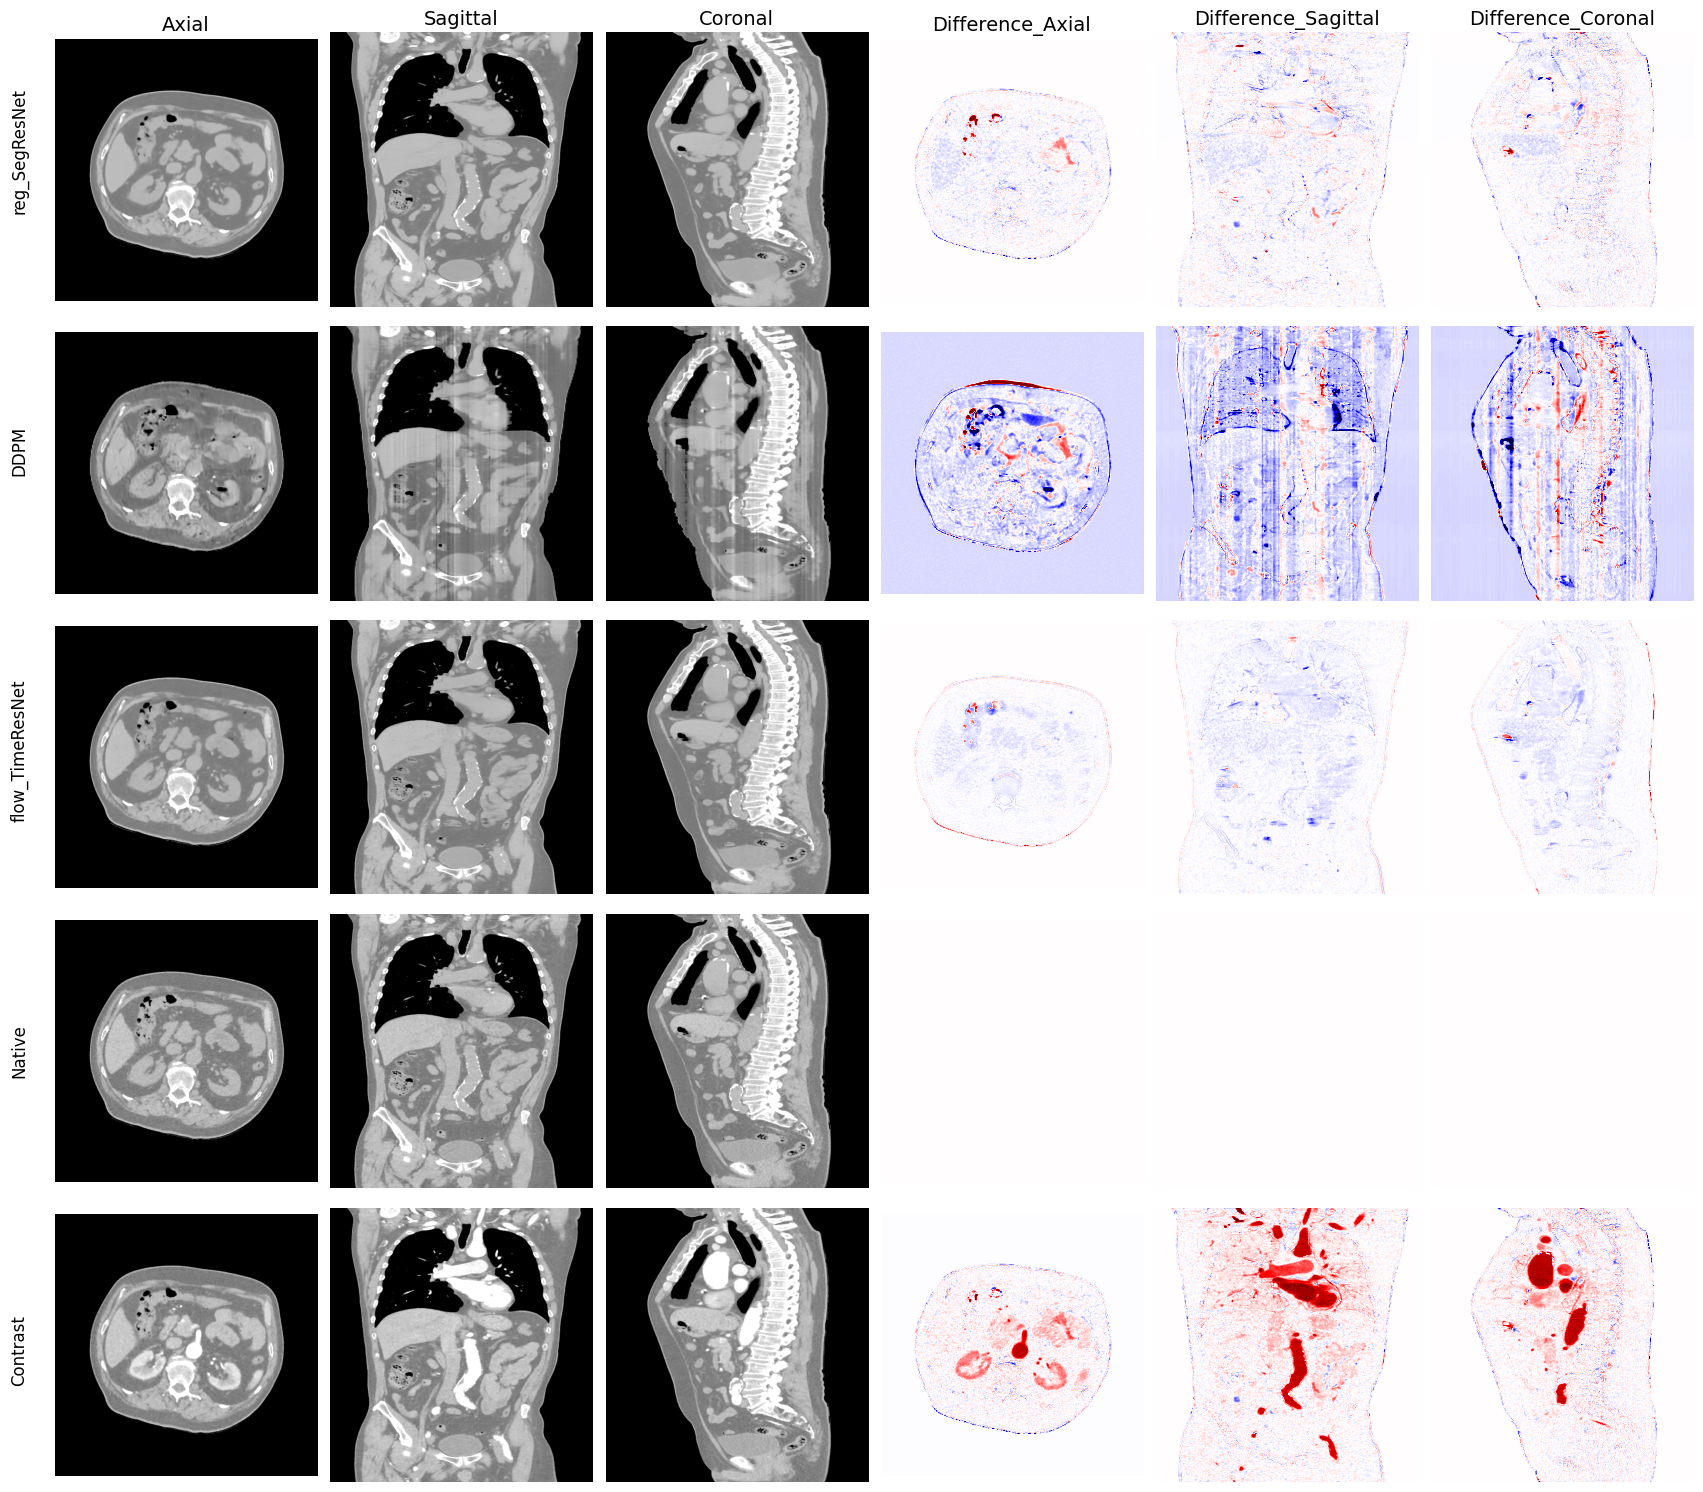

In [95]:
def create_projection_montage(volumes, output_path, coords=None, dpi=300):
    names = list(volumes.keys())
    n = len(names)
    fig, axes = plt.subplots(nrows=n, ncols=6, 
                             figsize=(18, 3*n), 
                             constrained_layout=False)
    fig.subplots_adjust(left=0.07, right=0.98, top=0.98, bottom=0.01, hspace=0.05, wspace=0.05)

    for j, title in enumerate(['Axial', 'Sagittal', 'Coronal', 'Difference_Axial', 'Difference_Sagittal', 'Difference_Coronal']):
        axes[0, j].set_title(title, fontsize=14)

    nat_axial, nat_sagittal, nat_coronal =  compute_projections(volumes['Native'], coords)
    for i, name in enumerate(names):
        vol = volumes[name]
        axial, sagittal, coronal = compute_projections(vol, coords)
        for j, img in enumerate((axial, sagittal, coronal)):
            ax = axes[i, j]
            ax.imshow(img.clip(-400, 200), cmap='gray')
            ax.axis('off')
        maxabs=400
        for j, (img, img_nat) in enumerate(zip((axial, sagittal, coronal), (nat_axial, nat_sagittal, nat_coronal)), start=3):
            ax = axes[i, j]
            if name in ['Native', 'Contrast']:
                img = img.clip(-1000, 1000)
            ax.imshow(
                (img-img_nat.clip(-1000, 1000)),
                cmap='seismic',
                vmin=-maxabs,
                vmax=+maxabs
            )
            ax.axis('off')
            
        y = 1 - (i + 0.5) / n
        fig.text(0.05, y, name, rotation='vertical', 
                 va='center', ha='center', fontsize=12)

    fig.savefig(output_path, dpi=dpi)
    print(f"Montage saved to '{output_path}'")

z = vols['Native'].shape[0]//2
y = vols['Native'].shape[1]//2
x = vols['Native'].shape[2]//2
create_projection_montage(vols, 'projection_montage.png', coords=(z, y, x))

In [98]:
for key in splits.keys():
    stats = []
    for idx in tqdm(splits[key]):
        image, _, _ = load_dicom(f'../data/series/{idx}/art.nii.gz')
        stats.append(image.shape[0])
    print(key, sum(stats))

100%|██████████| 80/80 [01:59<00:00,  1.49s/it]


train 34992


100%|██████████| 20/20 [00:24<00:00,  1.25s/it]


test 8197


100%|██████████| 20/20 [00:27<00:00,  1.39s/it]

holdout 9372
